# Simformer

`sbi` incorporates also the Simformer, a novel framework to provide an "all-in-one" solution for Simulation-Based Inference.

Similarly to the NPSE and the FMPE algorithms, the Simformer leverage score-based and flow-matching generative models to sample from the conditional distribution, leveraging a Transformer-based architecture.

While NPSE and FMPE limit themselves to predict the posterior $p(\theta|x)$ distributuion, the **Simformer** takes a more fundamental step. It aims to learn a single, unified model that can implicitly represent **any joint distribution** of $\theta$ and $x$, thereby unlocking a   range of inference capabilities from a single trained model.

At its heart, Simformer is a **Masked Conditional Model**. That is, instead of treating parameters ($\theta$) and data ($x$) separately, Simformer rather expects them as a single input vector, such a concatenation $\hat{\mathbf{x}} = [\theta, x]$. Which is then accompanied with two other tensors that represents dependencies between inputs:

- The **Condition Mask ($M_C$)**, which explicitly designates which variables in $\hat{\mathbf{x}}$ are **observed (to be conditioned on)** and which are **latent (to be inferred)**.
- The **Edge Mask ($M_E$)**, which inject prior knowledge about the **causal or statistical dependencies** between variables in $\hat{\mathbf{x}}$. By specifying which variables can "attend" to others in the Transformer aligment mechanism.

Most importantly, the Simformer can be trained using different condition and edge masks at different training steps, generating a final neural network which did not limit its learning process to a specific inference setting, but can be flexibly re-used with arbitrary condition and edge masks.

In this tutorial, we take a brief look at the API for the `Simformer`.

For more information, see:
- Gloeckler M. et al. "All-in-one simulation-based inference." ICML 2024.

We first start importing dependencies and preparing a simulator.

In [1]:
import torch

from sbi.analysis import pairplot
from sbi.inference import Simformer
from sbi.utils import BoxUniform

In [2]:
torch.manual_seed(0) # For reproductibility

# Example toy simulator
# Define the prior
num_dims = 3
num_sims = 10000
prior = BoxUniform(low=-torch.ones(num_dims), high=torch.ones(num_dims))

def simulator(theta):
    """Linear gaussian simulator."""
    return theta + 1.0 + torch.randn_like(theta) * 0.1

Differently from other sbi methods, the Simformer works by means unflattened variable features, i.e., we must train the Simformer on simulations that provide features of each variable in separate, trailing dimension. For our walkthrough we will implement the score-based Simformer, the flow-matching equivalent works by the same exact API.

In [3]:
# Produce simulations
theta = prior.sample((num_sims, 1))            # shape: (10000, 1, 3)
x = simulator(theta)                           # shape: (10000, 1, 3)
inputs = torch.cat([theta, x], dim=1)          # shape: (10000, 2, 3)

theta_o = torch.zeros(num_dims)
x_o = simulator(theta_o)

In fact, Simformer can also work without this final trailing dimension (e.g. a shape of the kind `(batch_dim, variable_dim)` instead of `(batch_dim, variable_dim, feat_dim)`), sbi will directly assume that `feat_dim=1`. Anyway, we will continue with the 3-dimensional implementation throughout this tutorial.

As for NPSE, the Simformer approximates the posterior distribution by learning its score function, i.e., gradient of the log-density, using the denoising score matching loss. Refer to [19_flowmatching_and_scorematching](#) and [20_score_based_methods_new_features.ipynb](#) for understanding denoising score matching.

>Note also that currently only the single-round version of Simformer is implemented currently.

In [4]:
# Instantiate Simformer and append simulations
inference = Simformer()
inference.append_simulations(inputs)

Notice how we only appended the `inputs` tensor, without providing any knowledge of dependencies within variables, or which are observed or latent (i.e., to be infered) in our problem. In other words, we did not pass any condition or edge mask.

Condition and edge masks will be rather generated at trainig time. Such generation can be ruled by the user passing either a `Callable`, a collection of masks (`list`, `set`, `Tensor`), or a fixed `Tensor`. If we do not specify anything sbi will automatically generate them:
- Condition masks will be generated according to a $\text{Bernoulli}(p=0.5)$, for degenerate cases in which the entire mask of a given sample collapse to full observed—i.e. full ones, a mechanism that randomly flips one variable at random take place
- Edge masks will be `None` (equivalent to a full tensor of ones, i.e., full attention)

In [5]:
# Train the score estimator
score_estimator = inference.train(max_num_epochs=100)

 Training neural network. Epochs trained: 101

Once the network is trained, we can proceed by building a conditional distribution of our choice. To do so, we must pass some fixed condition and edge masks.

In [6]:
# Build the conditional using the trained score estimator, and sample
conditional = inference.build_conditional(condition_mask=[False, True])
conditional_samples = conditional.sample((10000,), x=x_o)

/home/massimiliano/Projects/sbi/sbi/inference/potentials/vector_field_potential.py:51: UserWarning: The passed prior has no support property, transform will be constructed from mean and std. If the passed prior is supposed to be bounded consider implementing the prior.support property.
  theta_transform = mcmc_transform(
/home/massimiliano/Projects/sbi/sbi/utils/sbiutils.py:870: UserWarning: The passed discrete prior has no mean or stddev attribute, estimating them from samples to build affine standardizing transform.
  transform = prior_mean_std_transform(prior, device)


Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

Actually, the `build_conditional()` method returns a `NeuralPosterior` instance, despite the name, such object is still the conditional of our choice and will work as expected, we simply leverage the already available `NeuralPosterior` interface as it is general and powerful enough to provide us all the features we need. 

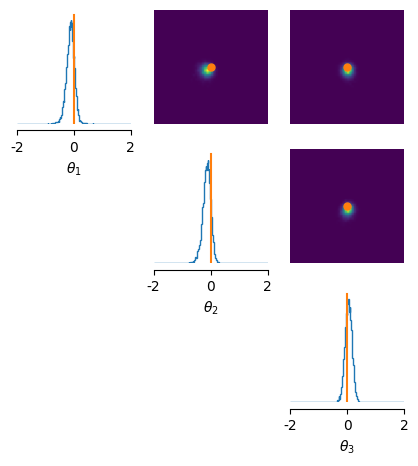

In [7]:
# plot posterior samples
fig, ax = pairplot(
    conditional_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

Then, the Simformer allows to create a different conditionals, still using the same trained neural network 

In [8]:
# Build the posterior using the trained score estimator, and sample
another_conditional = inference.build_conditional(condition_mask=[True, False])
another_conditional_samples = another_conditional.sample((10000,), x=theta_o)

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

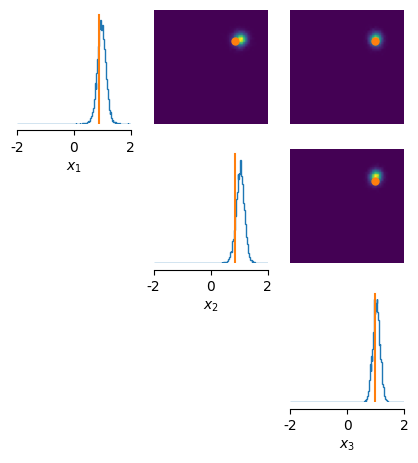

In [9]:
# plot likelihood samples
fig, ax = pairplot(
    another_conditional_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$x_1$", r"$x_2$", r"$x_3$"],
    points=x_o # add ground truth x
)

More precisely, the two distribution just infered are exactly the posterior and likelihood distribution, and they were both provided leveraging the same exact underlying neural network! From the Simformer perspective there is not concept of posterior vs. likelihood, as there is no concept of $\theta$'s and $x$'s: only a vector of *inputs* and corresponding *masks* that define relationships between them.

While the example provided is trivial, the Simformer becomes quite more interesting for more complex models, where there could exist more that two variables involved. And where the conditional distribution that one needs to infer is not assumed to be already choosen.

Nonetheless, the Simformer still allows to call the two common `build_posterior()` and `build_likelihood()` methods. As long as we first inform the Simformer which variables are intended as latent or observed **from the posterior perspective**.

In [10]:
inference.set_condition_indexes(new_posterior_latent_idx=[0], new_posterior_observed_idx=[1])

This setting of latent and posterior indexes *do not affect* the behaviour of the `build_conditional()` method, as it only relies on the masks passed when it is called. It simply informs the Simformer on how to interpret variables when `build_posterior()` and `build_likelihood()` are called. Again, note that the indexes passed must be interpret as latent and observed **from the posterior perspective**. These can also be set at Simformer init time through `posterior_latent_idx` and `posterior_observed_idx` parameters. 

In [11]:
posterior = inference.build_posterior()
posterior_samples = posterior.sample((10000,), x=x_o)

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

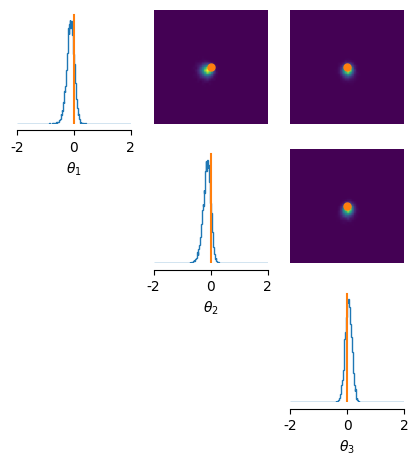

In [12]:
# plot posterior samples
fig, ax = pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

Indeed, the posterior just found is similar to the conditional infered in previous steps. We can similarly build the likelihood again.

In [13]:
likelihood = inference.build_likelihood()
likelihood_samples = likelihood.sample((10000,), x=theta_o)

Drawing 10000 posterior samples for 1 observations:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/499 [00:00<?, ?it/s]

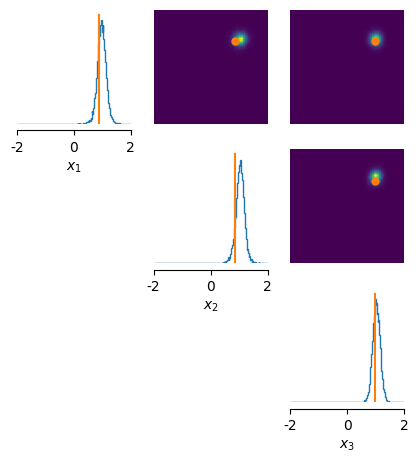

In [14]:
# plot posterior samples
fig, ax = pairplot(
    likelihood_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$x_1$", r"$x_2$", r"$x_3$"],
    points=x_o # add ground truth thetas
)